In [66]:
# Test driving the EM algorithm

import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hidden import infer
from hidden import dynamics
from hidden.optimize.base import OptClass

sns.set(style='darkgrid', palette="hls")
proj_dir = Path().resolve().parents[1]
plot_dir = proj_dir / "reports" / "figures"

hmm = dynamics.HMM(2, 2)
hmm.init_uniform_cycle(trans_rate=0.3, error_rate=0.2)
hmm.run_dynamics(500)

obs_ts = hmm.get_obs_ts()
state_ts = hmm.get_state_ts()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
# Now to run the BW algorithm
analyzer = infer.MarkovInfer(2, 2)

mat_perturb_A = np.array([
    [0.15, 0.10],
    [-0.15, -0.10]
])

mat_perturb_B = np.array([
    [-0.1, 0.06],
    [0.1, -0.06]
])

trans_mat_init = hmm.A + mat_perturb_A
obs_mat_init = hmm.B + mat_perturb_B

In [68]:
trans_mat_init

array([[0.85, 0.4 ],
       [0.15, 0.6 ]])

In [69]:
# First, test out the default behaviour
result_bw1 = analyzer.optimize(obs_ts, trans_mat_init, obs_mat_init, opt_type=OptClass.ExpMax)

Running Baum-Welch (EM) optimization...


In [70]:
# Next, we can pass in a few options:
#
# SUPPORTED ALGO_OPTIONS (defaults in parens)
# threshold (1e-8): Threshold for the maximum of the matrix norm of update sizes to terminate optimization
# maxiter (5000): maximum number of iterations
# track_optimization (False): boolean flag for if you want to periodically track the optimization state (values of A and B matrices)
# tracking_interval (100): Number of iterations between tracking of state (only impactful if track_optimization is True)
# tracking_norm ("fro"): Matrix norm to use for calcualting update size (for threshold), 'fro' is fromenus norm, scipy.linalg.norm has documentation for other options

# Invalid/unsupported arguments will be reported in a warning message, so you should be aware of any misspellings etc. at runtime

algo_options = {
    "threshold": 1e-6,
    "maxiter": 200,
    "track_optimization": True,
    "tracking_interval": 10,
    "INVALID OPTION": "TEST"
}

result_bw2 = analyzer.optimize(obs_ts, trans_mat_init, obs_mat_init, opt_type=OptClass.ExpMax, algo_opts=algo_options)

c:\users\slarge\code\hmm\hidden\optimize\optimization.py:177: RuntimeWarning: Unrecognized optimizer options {'INVALID OPTION': 'TEST'}, proceeding without using them. See documentation for valid initialization options for EM algorithm...
  warnings.warn(


Running Baum-Welch (EM) optimization...


In [71]:
# The results are in custom data straucture
result_bw1.summary

{'trans_matrix_opt': array([[0.65617241, 0.34892223],
        [0.34382759, 0.65107777]]),
 'obs_matrix_opt': array([[0.84134484, 0.16113163],
        [0.15865516, 0.83886837]]),
 'iterations': 2092,
 'final_iteration_norm': 9.981386807797866e-09,
 'success': True,
 'metadata': []}

In [ ]:
# And then we will see the keys for additional tracking data in the result summary of the second run
result_bw2.summary

{'trans_matrix_opt': array([[0.6826154 , 0.36859247],
        [0.3173846 , 0.63140753]]),
 'obs_matrix_opt': array([[0.90839391, 0.09700709],
        [0.09160609, 0.90299291]]),
 'iterations': 200,
 'final_iteration_norm': 6.446096883332681e-05,
 'success': True,
 'metadata': ['trans_tracker', 'obs_tracker']}

In [72]:
# Looking at the result namespaces (the __dict__ attribute) we can see the other things associated with the result
# Specifically, update_size is the time series of update changes, which can be used to monitor convergence
result_bw1.__dict__.keys()


dict_keys(['_success', '_algo_name', '_results', '_report', 'update_size_tracking', '_iterations', 'A', 'B', 'metadata'])

In [73]:
# This is the same here, the difference is the keys accessible on the result metadata
result_bw2.__dict__.keys()

dict_keys(['_success', '_algo_name', '_results', '_report', 'update_size_tracking', '_iterations', 'A', 'B', 'metadata'])

In [74]:
result_bw1.metadata.keys(), result_bw2.metadata.keys()

(dict_keys([]), dict_keys(['trans_tracker', 'obs_tracker']))

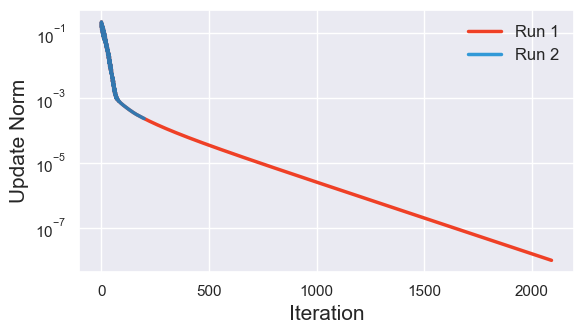

In [75]:
# So, from this we can, we can look at the convergence in both cases

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

ax.plot(result_bw1.update_size_tracking, label="Run 1", linewidth=2.5, color=sns.xkcd_rgb["tomato"])
ax.plot(result_bw2.update_size_tracking, label="Run 2", linewidth=2.5, color=sns.xkcd_rgb["cerulean"], alpha=0.8)
ax.set_yscale("log")
# ax.set_xscale("log")

ax.set_xlabel(r"Iteration", fontsize=15)
ax.set_ylabel(r"Update Norm", fontsize=15)
ax.legend(fontsize=12, frameon=False)
plt.tight_layout()
plt.savefig(plot_dir / "convergence_tracking_bw.pdf")
plt.show()

In [76]:
# We can rerun the second model, but with a larger max iteration and look at
# how the actual parameter values change over time as well
algo_options = {
    "track_optimization": True,
    "tracking_interval": 1,
    "maxiter": 5000,
    "threshold": 1e-6
}

result_bw3 = analyzer.optimize(obs_ts, trans_mat_init, obs_mat_init, opt_type=OptClass.ExpMax, algo_opts=algo_options)


Running Baum-Welch (EM) optimization...


In [77]:
result_bw3.summary

{'trans_matrix_opt': array([[0.65625484, 0.3488407 ],
        [0.34374516, 0.6511593 ]]),
 'obs_matrix_opt': array([[0.84124823, 0.16122885],
        [0.15875177, 0.83877115]]),
 'iterations': 1187,
 'final_iteration_norm': 9.999193720833897e-07,
 'success': True,
 'metadata': ['trans_tracker', 'obs_tracker']}

In [78]:
trans_tracker = np.zeros((2, 2, result_bw3._iterations))
obs_tracker = np.zeros((2, 2, result_bw3._iterations))

for i in range(result_bw3._iterations):
    trans_tracker[:, :, i] = result_bw3.metadata["trans_tracker"][i]
    obs_tracker[:, :, i] = result_bw3.metadata["obs_tracker"][i]


In [79]:
trans_tracker.shape, obs_tracker.shape

((2, 2, 1187), (2, 2, 1187))

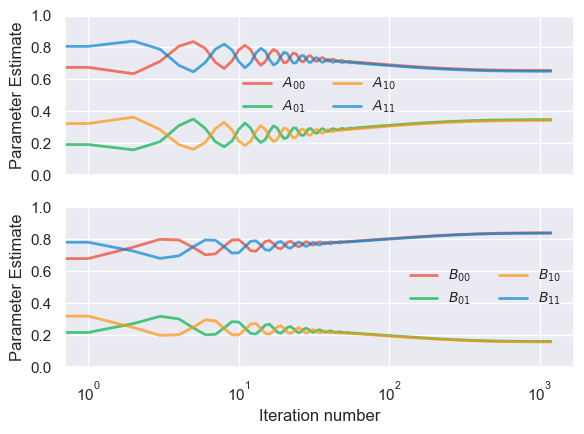

In [80]:
fig, ax = plt.subplots(2, 1, figsize=(6, 4.5), sharex=True, sharey=True)

ax[0].plot(trans_tracker[0, 0, :], label=r"$ A_{ 00 } $", linewidth=2.0, color=sns.xkcd_rgb["tomato"], alpha=0.7)
ax[0].plot(trans_tracker[0, 1, :], label=r"$ A_{ 01 } $", linewidth=2.0, color=sns.xkcd_rgb["shamrock"], alpha=0.7)
ax[0].plot(trans_tracker[1, 0, :], label=r"$ A_{ 10 } $", linewidth=2.0, color=sns.xkcd_rgb["tangerine"], alpha=0.7)
ax[0].plot(trans_tracker[1, 1, :], label=r"$ A_{ 11 } $", linewidth=2.0, color=sns.xkcd_rgb["cerulean"], alpha=0.7)

ax[1].plot(obs_tracker[0, 0, :], label=r"$ B_{ 00 } $", linewidth=2.0, color=sns.xkcd_rgb["tomato"], alpha=0.7)
ax[1].plot(obs_tracker[0, 1, :], label=r"$ B_{ 01 } $", linewidth=2.0, color=sns.xkcd_rgb["shamrock"], alpha=0.7)
ax[1].plot(obs_tracker[1, 0, :], label=r"$ B_{ 10 } $", linewidth=2.0, color=sns.xkcd_rgb["tangerine"], alpha=0.7)
ax[1].plot(obs_tracker[1, 1, :], label=r"$ B_{ 11 } $", linewidth=2.0, color=sns.xkcd_rgb["cerulean"], alpha=0.7)

ax[0].set_ylim([0, 1])
ax[0].set_xscale('log')
ax[0].legend(fontsize=10, frameon=False, ncol=2)
ax[1].legend(fontsize=10, frameon=False, ncol=2)
ax[1].set_xlabel(r"Iteration number", fontsize=12)
ax[0].set_ylabel(r"Parameter Estimate", fontsize=12)
ax[1].set_ylabel(r"Parameter Estimate", fontsize=12)
plt.tight_layout()
plt.savefig(plot_dir / "param_tracking_bw.pdf")
plt.show()


In [83]:
# because here we actually simulated the data, we can look at how the
# optimization compares to the true parameter values

result_bw3.A, hmm.A, (result_bw3.A - hmm.A), (trans_mat_init - hmm.A)

(array([[0.65625484, 0.3488407 ],
        [0.34374516, 0.6511593 ]]),
 array([[0.7, 0.3],
        [0.3, 0.7]]),
 array([[-0.04374516,  0.0488407 ],
        [ 0.04374516, -0.0488407 ]]),
 array([[ 0.15,  0.1 ],
        [-0.15, -0.1 ]]))

In [84]:
result_bw3.B, hmm.B, (result_bw3.B - hmm.B), (obs_mat_init - hmm.B)

(array([[0.84124823, 0.16122885],
        [0.15875177, 0.83877115]]),
 array([[0.8, 0.2],
        [0.2, 0.8]]),
 array([[ 0.04124823, -0.03877115],
        [-0.04124823,  0.03877115]]),
 array([[-0.1 ,  0.06],
        [ 0.1 , -0.06]]))